In [1]:
# 8. Автоэнкодер для уменьшения размерности данных с последующей классификацией: Создание автоэнкодера, 
# который снижает размерность высокоразмерных данных, после чего сжатые представления используются для задач классификации.

In [2]:
# делаем автоенкодер

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class Autoencoder1(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_p, inner_dim):
        super(Autoencoder1, self).__init__()

        # Энкодер
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.relu1 = nn.ReLU()
        self.do1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(inner_dim, encoding_dim)
        self.relu2 = nn.ReLU()
        #self.sigmoid2 = nn.Sigmoid()
        
        # Декодер
        self.fc3 = nn.Linear(encoding_dim, inner_dim)
        self.relu3 = nn.ReLU()
        self.do2 = nn.Dropout(p=dropout_p)
        self.fc4 = nn.Linear(inner_dim, input_dim)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.do1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        return x

    def decode(self, z):
        z = self.fc3(z)
        z = self.relu3(z)
        z = self.do2(z)
        z = self.fc4(z)
        z = self.sigmoid(z)
        return z
        
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        self.latent_layer = encoded
        return encoded, decoded, x
        
        
print('ok')

ok


In [4]:
# загружаем данные

In [5]:
import pandas as pd

def print_separator(title):
    print("\n" + "="*80)
    print(title)
    print("="*80 + "\n")

print("load csv")
dataset = pd.read_csv('../hw1/hw1ex2-rates.csv')
dataset['Date'] = pd.to_datetime(dataset['dt'])

print(dataset)
print(dataset.head())
print(dataset.info())
print(dataset.describe())

load csv
                     dt    open   close    high     low                Date
0      2008.01.02 10:00  1.4661  1.4661  1.4666  1.4658 2008-01-02 10:00:00
1      2008.01.02 10:15  1.4660  1.4652  1.4661  1.4651 2008-01-02 10:15:00
2      2008.01.02 10:30  1.4651  1.4657  1.4657  1.4651 2008-01-02 10:30:00
3      2008.01.02 10:45  1.4656  1.4653  1.4657  1.4650 2008-01-02 10:45:00
4      2008.01.02 11:00  1.4652  1.4655  1.4663  1.4650 2008-01-02 11:00:00
...                 ...     ...     ...     ...     ...                 ...
24409  2008.12.31 16:45  1.3965  1.3898  1.3966  1.3890 2008-12-31 16:45:00
24410  2008.12.31 17:00  1.3896  1.3917  1.3932  1.3887 2008-12-31 17:00:00
24411  2008.12.31 17:15  1.3919  1.3971  1.3971  1.3915 2008-12-31 17:15:00
24412  2008.12.31 17:30  1.3974  1.3956  1.3984  1.3954 2008-12-31 17:30:00
24413  2008.12.31 17:45  1.3957  1.3917  1.3957  1.3914 2008-12-31 17:45:00

[24414 rows x 6 columns]
                 dt    open   close    high     low  

In [6]:
# добавляем лаги

In [7]:
lag = 15
for i in range(1, lag + 1):
        dataset[f'lag_{i}'] = dataset['close'].shift(i)

dataset.dropna(inplace=True)

In [8]:
# создаем метки для классификации
# 1 up, 2 - down, 0 - none

In [9]:
labels = []
close_prices = dataset['close'].values
labels.insert(0, 0)
for i in range(1, len(close_prices)):
    change = close_prices[i] - close_prices[i - 1]
    if change > 0.0:
        labels.append(1)
    elif change < -0.0:
        labels.append(2)
    else:
        labels.append(0)

dataset['labels'] = labels

dataset = dataset[dataset['labels'] != 0]

print(dataset)
print(dataset.head())
print(dataset.info())
print(dataset.describe())

                     dt    open   close    high     low                Date  \
16     2008.01.02 14:00  1.4689  1.4685  1.4698  1.4682 2008-01-02 14:00:00   
17     2008.01.02 14:15  1.4686  1.4676  1.4687  1.4670 2008-01-02 14:15:00   
18     2008.01.02 14:30  1.4677  1.4666  1.4681  1.4664 2008-01-02 14:30:00   
19     2008.01.02 14:45  1.4667  1.4661  1.4668  1.4661 2008-01-02 14:45:00   
20     2008.01.02 15:00  1.4662  1.4666  1.4667  1.4656 2008-01-02 15:00:00   
...                 ...     ...     ...     ...     ...                 ...   
24409  2008.12.31 16:45  1.3965  1.3898  1.3966  1.3890 2008-12-31 16:45:00   
24410  2008.12.31 17:00  1.3896  1.3917  1.3932  1.3887 2008-12-31 17:00:00   
24411  2008.12.31 17:15  1.3919  1.3971  1.3971  1.3915 2008-12-31 17:15:00   
24412  2008.12.31 17:30  1.3974  1.3956  1.3984  1.3954 2008-12-31 17:30:00   
24413  2008.12.31 17:45  1.3957  1.3917  1.3957  1.3914 2008-12-31 17:45:00   

        lag_1   lag_2   lag_3   lag_4  ...   lag_7 

In [10]:
# создаем датасеты для обучения

In [11]:
from sklearn.model_selection import train_test_split

labels_ds = dataset[['labels']].copy()
labels_ds = pd.DataFrame(labels_ds)

features = dataset.drop('labels', axis=1)
features.drop('dt', axis=1, inplace=True)
features.drop('Date', axis=1, inplace=True)

print('features')
print(features.head())
print('labels')
print(labels_ds.head())

features
      open   close    high     low   lag_1   lag_2   lag_3   lag_4   lag_5  \
16  1.4689  1.4685  1.4698  1.4682  1.4688  1.4685  1.4691  1.4696  1.4685   
17  1.4686  1.4676  1.4687  1.4670  1.4685  1.4688  1.4685  1.4691  1.4696   
18  1.4677  1.4666  1.4681  1.4664  1.4676  1.4685  1.4688  1.4685  1.4691   
19  1.4667  1.4661  1.4668  1.4661  1.4666  1.4676  1.4685  1.4688  1.4685   
20  1.4662  1.4666  1.4667  1.4656  1.4661  1.4666  1.4676  1.4685  1.4688   

     lag_6   lag_7   lag_8   lag_9  lag_10  lag_11  lag_12  lag_13  lag_14  \
16  1.4686  1.4687  1.4687  1.4678  1.4668  1.4663  1.4655  1.4653  1.4657   
17  1.4685  1.4686  1.4687  1.4687  1.4678  1.4668  1.4663  1.4655  1.4653   
18  1.4696  1.4685  1.4686  1.4687  1.4687  1.4678  1.4668  1.4663  1.4655   
19  1.4691  1.4696  1.4685  1.4686  1.4687  1.4687  1.4678  1.4668  1.4663   
20  1.4685  1.4691  1.4696  1.4685  1.4686  1.4687  1.4687  1.4678  1.4668   

    lag_15  
16  1.4652  
17  1.4657  
18  1.4653  
1

In [12]:
# матрица корреляции

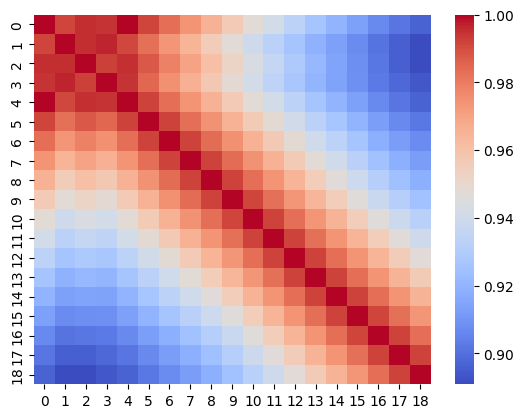

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = np.corrcoef(features[:1000].T)
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

In [14]:
# распределение классов 

Index(['labels'], dtype='object')
False


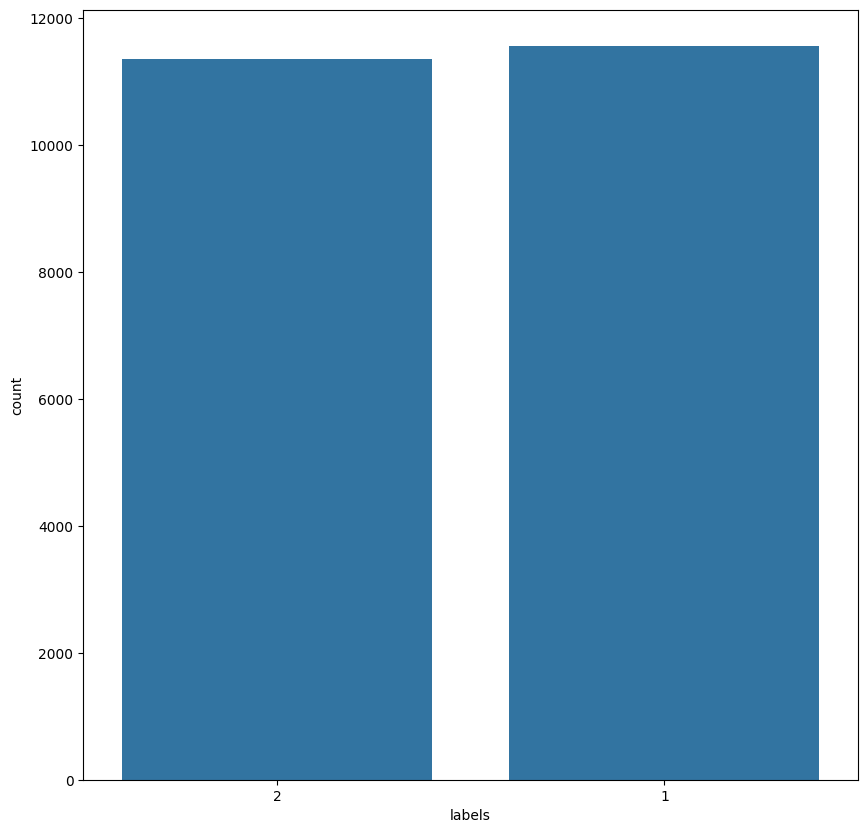

In [15]:
print(labels_ds.columns)
print(labels_ds.empty)
labels_ds['labels'] = labels_ds['labels'].astype(str)

plt.figure(figsize=(10,10))
sns.countplot(x='labels', data=labels_ds);
plt.show()

In [16]:
# используем GPU

In [17]:
import torch

print(torch.cuda.is_available())  # Должно вернуть True, если GPU доступен
print(torch.cuda.device_count())  # Количество доступных GPU
print(torch.cuda.get_device_name(0))  # Название первого GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
1
NVIDIA GeForce GTX 1650
cuda


In [18]:
# функция создания автоенкодера

In [19]:
import torch.optim as optim
from sklearn.linear_model import LogisticRegression

def create_autoencoder(input_dim = 19, encoding_dim = 4, dropout_p = 0.3, learning_rate = 0.0001, inner_dim = 128):
    model = Autoencoder1(input_dim, encoding_dim, dropout_p, inner_dim).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    classifier = LogisticRegression(random_state = 42)
    return model, optimizer, classifier

print('ok')

ok


In [20]:
# функции обучения и тестирования

In [21]:
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F
from sklearn.metrics import accuracy_score


train_losses = []
test_losses = []
accuracy_losses = []

# Функция обучения
def train(epoch, train_loader, model, optimizer):
    features_encoded = []
    model.train()
    train_loss = 0
    for batch_idx, (data, lbls) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        encoded, decoded, x = model(data)
        
        train_loss = F.mse_loss(x, decoded)
        
        train_loss.backward()
        optimizer.step()

        
        
        features_encoded.append(encoded)
        
        if batch_idx % 100 == 0:
            print(f"Эпоха {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tПотеря: {train_loss.item() / len(data):.4f}", end = '\r', flush = True)

    train_losses.append(train_loss.cpu().item())
    
    return train_loss / len(train_loader.dataset), features_encoded
    
# Функция тестирования
def test(epoch, test_loader, model, optimizer):
    model.eval()
    test_loss = 0
    features_encoded = []
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            encoded, decoded, x = model(data)
            test_loss += F.mse_loss(x, decoded)
            features_encoded.append(encoded)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    return test_loss, features_encoded

def test_classifier(classifier, encoded_features_train, encoded_features_test):
    yyy3 = y_train.values.ravel()
    classifier.fit(encoded_features_train, yyy3)
    y_pred = classifier.predict(encoded_features_test)
    yyy = y_pred.ravel()
    yyy2 = y_test.values.ravel()
    accuracy = accuracy_score(yyy2, yyy)

    accuracy_losses.append(accuracy)
    
    return accuracy
    


print('ok')

ok


In [22]:
# разбиваем данные на обучающую и тестовую выборки

In [23]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

batch_size = 19

X_train, X_test, y_train, y_test = train_test_split(features, labels_ds, test_size=0.3, random_state=42, stratify=labels_ds)

scaler = StandardScaler()
features_std = scaler.fit_transform(features)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scalerMM = MinMaxScaler(feature_range=(0, 1))
scalerMM.fit_transform(features_std)
X_train = scalerMM.transform(X_train)
X_test = scalerMM.transform(X_test)


print('scaled X_train:')
print(X_train.min(), X_train.max())

print(y_train.dtypes)
y_train = y_train.astype(int)
print(y_train.dtypes)
y_test = y_test.astype(int)

features_trch_train = torch.tensor(X_train, dtype=torch.float32)
labels_trch_train = torch.tensor(y_train.values, dtype=torch.int8)
dataset_tns_train = TensorDataset(features_trch_train, labels_trch_train)
data_loader_train = DataLoader(dataset_tns_train, batch_size=batch_size, shuffle=True)

features_trch_test = torch.tensor(X_test, dtype=torch.float32)
labels_trch_test = torch.tensor(y_test.values, dtype=torch.int8)
dataset_tns_test = TensorDataset(features_trch_test, labels_trch_test)
data_loader_test = DataLoader(dataset_tns_test, batch_size=batch_size, shuffle=False)




scaled X_train:
0.0 1.0
labels    object
dtype: object
labels    int64
dtype: object


In [24]:
# обучаем автоенкодер

In [29]:

epochs = 20
train_losses = []
test_losses = []
accuracy_losses = []

model, optimizer, classifier = create_autoencoder(input_dim = 19, encoding_dim = 6, dropout_p = 0.2, learning_rate = 0.00001, inner_dim=512)


# Обучение модели
for epoch in range(1, epochs + 1):
    tsl, _ = train(epoch, data_loader_train, model, optimizer)
    tl, _ = test(epoch, data_loader_test, model, optimizer)
    
    features_trch_train_d = features_trch_train.to(device)
    features_trch_test_d = features_trch_test.to(device)
    
    model.eval()
    with torch.no_grad():
        #model.to(device)
        fe_train, fd_train, _ = model(features_trch_train_d)
        fe_test, fd_test, _ = model(features_trch_test_d)

    fe_train = fe_train.cpu()
    fe_test = fe_test.cpu()
    fd_train = fd_train.cpu()
    fd_test = fd_test.cpu()
    
    acc = test_classifier(classifier, fe_train, fe_test)

    print(f"====> Эпоха {epoch} Средняя потеря: {tsl:.13f} Тестовая потеря: {tl:.13f} accuracy: {acc:.13f}")




====> Эпоха 1 Средняя потеря: 0.0000038266267 Тестовая потеря: 0.0024332266767 accuracy: 0.5042175683537
====> Эпоха 2 Средняя потеря: 0.0000002803976 Тестовая потеря: 0.0015249062562 accuracy: 0.5042175683537
====> Эпоха 3 Средняя потеря: 0.0000009800755 Тестовая потеря: 0.0008610571967 accuracy: 0.5042175683537
====> Эпоха 4 Средняя потеря: 0.0000008489626 Тестовая потеря: 0.0003256119089 accuracy: 0.5079988365329
====> Эпоха 5 Средняя потеря: 0.0000003304127 Тестовая потеря: 0.0001154261772 accuracy: 0.5031995346131
====> Эпоха 6 Средняя потеря: 0.0000001365364 Тестовая потеря: 0.0000701729878 accuracy: 0.5066899360093
====> Эпоха 7 Средняя потеря: 0.0000001417819 Тестовая потеря: 0.0000510272184 accuracy: 0.5042175683537
====> Эпоха 8 Средняя потеря: 0.0000000886169 Тестовая потеря: 0.0000390265195 accuracy: 0.5042175683537
====> Эпоха 9 Средняя потеря: 0.0000000700130 Тестовая потеря: 0.0000310745709 accuracy: 0.5042175683537
====> Эпоха 10 Средняя потеря: 0.0000000878648 Тестовая

In [26]:
# печатаем отчет

In [30]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def print_report(classifier_l, X_train_l, y_train_l, X_test_l, y_test_l):
    classifier.fit(X_train_l, y_train_l)
    y_pred_l = classifier.predict(X_test_l)
    print("\nClassification Report:")
    print(classification_report(y_test_l, y_pred_l))
    conf_matrix = confusion_matrix(y_test_l, y_pred_l)
    print("Матрица ошибок:")
    print(conf_matrix)


print_separator(f'Входной датасет:')
print_report(classifier, X_train, y_train, X_test, y_test)

print_separator(f'Закодированный слой:')
print_report(classifier, fe_train, y_train.values.ravel(), fe_test, y_test)

print_separator(f'Раскодированный слой:')
print_report(classifier, fd_train, y_train.values.ravel(), fd_test, y_test)



Входной датасет:


Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.85      0.75      3467
           2       0.80      0.59      0.68      3409

    accuracy                           0.72      6876
   macro avg       0.74      0.72      0.72      6876
weighted avg       0.74      0.72      0.72      6876

Матрица ошибок:
[[2953  514]
 [1404 2005]]

Закодированный слой:


Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.91      0.65      3467
           2       0.48      0.09      0.14      3409

    accuracy                           0.50      6876
   macro avg       0.49      0.50      0.40      6876
weighted avg       0.49      0.50      0.40      6876

Матрица ошибок:
[[3149  318]
 [3118  291]]

Раскодированный слой:


Classification Report:
              precision    recall  f1-score   support

           1       0.50      1.00      0.67      3467
           2 

D:\progs\python\python3.12.6\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\progs\python\python3.12.6\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\progs\python\python3.12.6\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\progs\python\python3.12.6\Lib\site-packages\sklearn\metrics\_classification.py:

In [28]:
# визуализация потерь

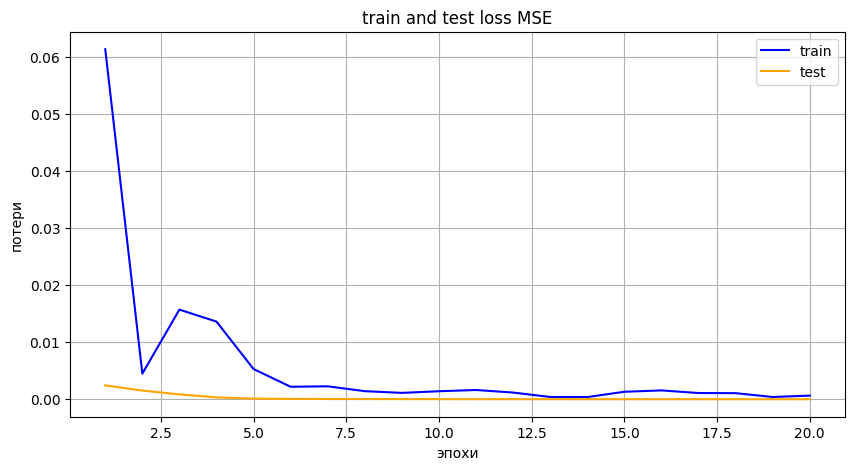

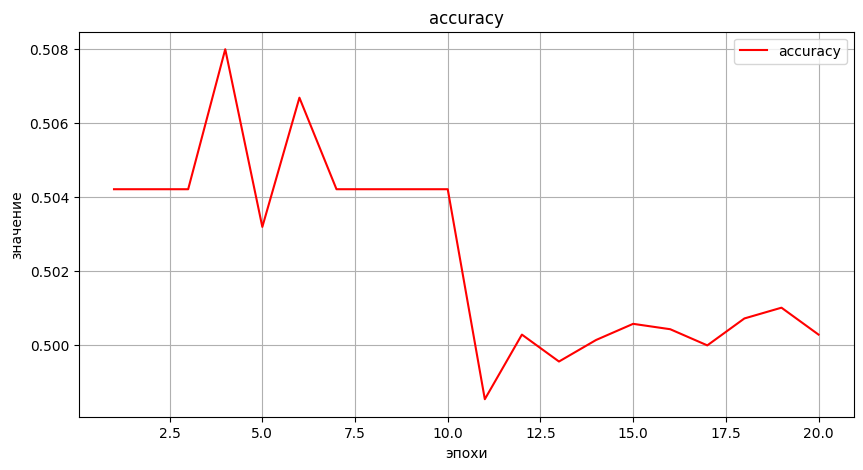

In [31]:
#print(train_losses)
#print(test_losses)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='train', color='blue')
plt.plot(range(1, epochs + 1), torch.stack(test_losses).cpu(), label='test', color='orange')
plt.title('train and test loss MSE')
plt.xlabel('эпохи')
plt.ylabel('потери')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), accuracy_losses, label='accuracy', color='red')
plt.title('accuracy')
plt.xlabel('эпохи')
plt.ylabel('значение')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# функция визуализации T-SNE

In [32]:
from sklearn.manifold import TSNE

def show_tsne(features_sw):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features_sw)
    
    print(tsne_results[:, 0].shape)
    print(tsne_results[:, 1].shape)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.values, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Classes')
    plt.title('t-SNE')
    plt.xlabel('t-sne 1')
    plt.ylabel('t-sne 2')
    plt.show()

print('ok')

ok


In [33]:
print(fe_test)
print('---------------------------')
print(fd_test)


tensor([[0.0000, 1.0726, 0.0000, 0.9527, 0.6152, 0.9509],
        [0.0000, 1.2188, 0.0000, 1.0890, 0.5273, 1.0676],
        [0.4322, 1.8526, 0.0075, 1.6821, 0.1485, 1.5691],
        ...,
        [0.0077, 1.3116, 0.0000, 1.1769, 0.4721, 1.1441],
        [0.4821, 1.9141, 0.0166, 1.7419, 0.1118, 1.6262],
        [0.5743, 2.0508, 0.0382, 1.8709, 0.0462, 1.7375]])
---------------------------
tensor([[0.5900, 0.5890, 0.5874,  ..., 0.5918, 0.5923, 0.5903],
        [0.6455, 0.6470, 0.6422,  ..., 0.6474, 0.6478, 0.6467],
        [0.9072, 0.9055, 0.9017,  ..., 0.9064, 0.9067, 0.9063],
        ...,
        [0.6817, 0.6839, 0.6774,  ..., 0.6827, 0.6831, 0.6829],
        [0.9221, 0.9206, 0.9170,  ..., 0.9216, 0.9216, 0.9213],
        [0.9446, 0.9437, 0.9400,  ..., 0.9445, 0.9440, 0.9443]])


In [33]:
# визуализация слоев автоекодера


Исходные фичи

(6876,)
(6876,)


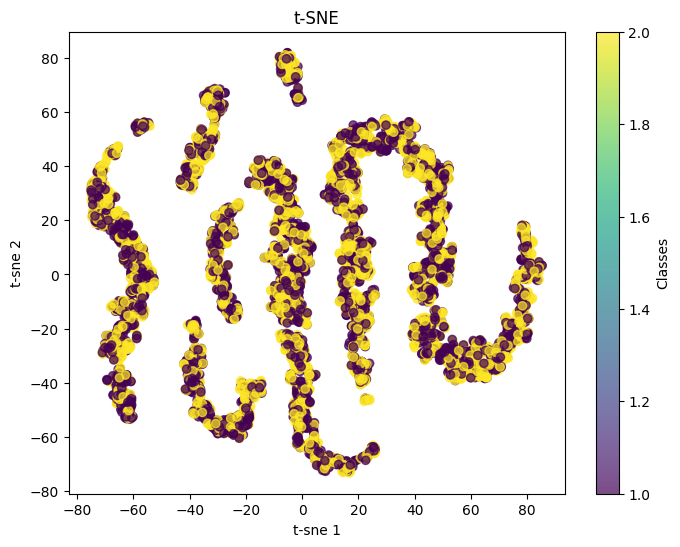


Закодированный слой

(6876,)
(6876,)


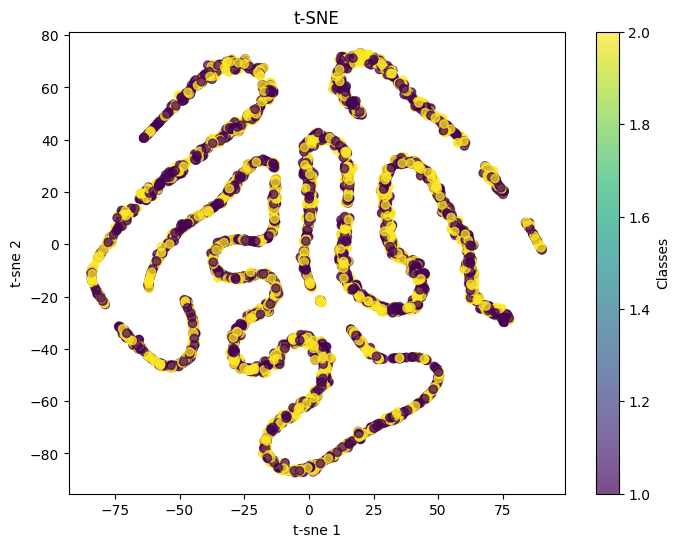


Раскодированный слой

(6876,)
(6876,)


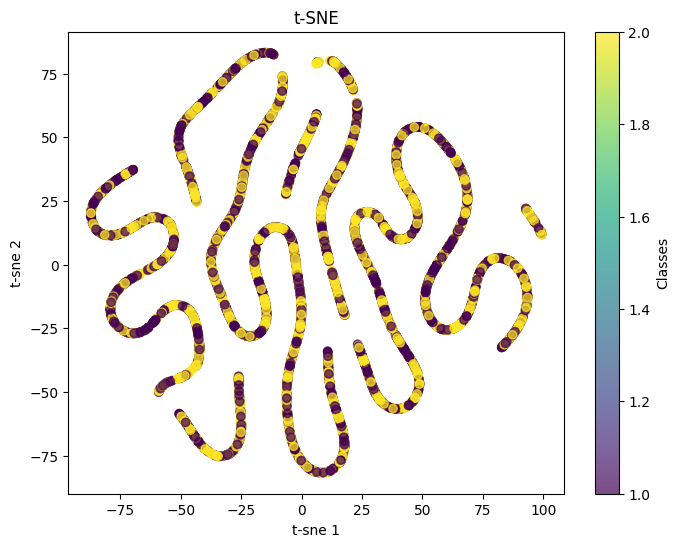

In [34]:
print_separator('Исходные фичи')
show_tsne(X_test)
print_separator('Закодированный слой')
show_tsne(fe_test)
print_separator('Раскодированный слой')
show_tsne(fd_test)
